# NCS Tutorial

                              By Allen Ou, last modified on 07/17, 2018.

The objective of this tutorial is to :
-  learn how to use ncs for prediction

## 1. Setup everything needed for prediction

### Import some relevant libraries

In [1]:
import numpy as np
import rospy
import rospkg
import math
import cv2
from cv_bridge import CvBridge, CvBridgeError
from mvnc import mvncapi as mvnc
from matplotlib import pyplot as plt
rospack = rospkg.RosPack()

### Setup some parameter

In [2]:
omega_gain = 8.3
device_work = False
model = "graph"
mvnc.SetGlobalOption(mvnc.GlobalOption.LOG_LEVEL, 2)
dim = (101, 101) #(width, height)

### Check if NCS is detected

In [3]:
devices = mvnc.EnumerateDevices()
if len(devices) == 0:
    device_work = False
    print('NCS device not found')
else:
    device_work = True
    print('NCS device found')
    #self.initialDevice()

NCS device found


### Initialize NCS

In [4]:
#If you want to re-open an ncs device, plug out it first and re-insert it again
#or there'll be an error
#set the blob, label and graph
device = mvnc.Device(devices[0])
device.OpenDevice()
network_blob = "models/" + model

#Load blob
with open(network_blob, mode='rb') as f:
        blob = f.read()

graph = device.AllocateGraph(blob)


## 2. Start predict

### Read a picture first

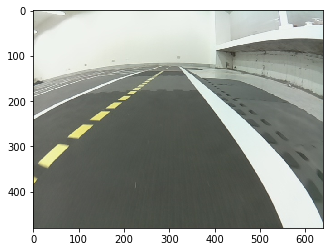

In [9]:
img = cv2.imread('images/road_sample.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)

### Process the picture to NCS specified size and type

(<matplotlib.text.Text at 0x7f23041e70d0>,
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

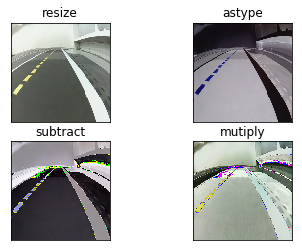

In [10]:
img_p = img
img_p = cv2.resize(img_p, dim)
plt.subplot(221),plt.imshow(img_p)
plt.title('resize'), plt.xticks([]), plt.yticks([])

img_p = img_p.astype(np.float32)
plt.subplot(222),plt.imshow(img_p)
plt.title('astype'), plt.xticks([]), plt.yticks([])

img_m = np.zeros((dim[1], dim[0], 3), np.float32)
img_m[:] = (128.0)
img_p = cv2.subtract(img_p, img_m)
plt.subplot(223),plt.imshow(img_p)
plt.title('subtract'), plt.xticks([]), plt.yticks([])

img_p = img_p * 0.0078125
plt.subplot(224),plt.imshow(img_p)
plt.title('mutiply'), plt.xticks([]), plt.yticks([])

### Send the processed image to NCS for prediction

In [11]:
%time
graph.LoadTensor(img_p.astype(np.float16), 'user object')
output, userobj = graph.GetResult()
top1 = output.argmax()
omega = (top1 *(2/14.) - 1) * 8.3
print omega

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.01 µs
0.0


## 3. Check if the prediction is correct or not

### Draw a vector pointing to the predicted direction on the image

320 384 320 284


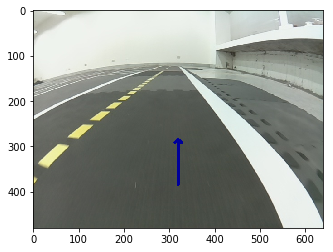

In [12]:
line_length = 100
height, width, channel = img.shape
bias = math.pi/2
direction = -(omega + bias)

x1 = int(round(width*0.5))
y1 = int(round(height*0.8))

x2 = int(round(x1 + line_length * math.cos(direction)))
y2 = int(round(y1 + line_length * math.sin(direction)))

print x1,y1,x2,y2
img_check = img
img_check = cv2.arrowedLine(img_check,(x1,y1),(x2,y2),(0,0,155),5)
plt.imshow(img_check)